In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from joblib import load, dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score,log_loss


credentials_path = r"service_account_json_file_path"
credentials = service_account.Credentials.from_service_account_file(credentials_path)
project_id = "bq_project_id"

sql = """

SELECT agg.*,val.* EXCEPT (user_pseudo_id), ltv90.itemRevenue90 FROM

(select * from 
(SELECT 
user_pseudo_id,
traffic_source.medium,
traffic_source.name,
traffic_source.source,
device.mobile_brand_name,
geo.country,
device.category,
row_number() OVER (PARTITION BY user_pseudo_id order by event_timestamp asc) as cnt
FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15)
WHERE cnt = 1) as agg

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,
--device.category,
--device.mobile_brand_name,
--geo.country,
--geo.city,
--geo.region,
--traffic_source.medium,
--traffic_source.name,
--traffic_source.source,
count(distinct (select value.int_value from unnest (event_params) WHERE KEY = 'ga_session_id')) as sessionCnt,
count(distinct case when event_name = 'session_start' THEN date(timestamp_micros(event_timestamp))END) as sessionDate,
count(distinct item_brand) itemBrandCount,
count(distinct item_category) itemCatCount,
count(distinct case when event_name = 'view_promotion' THEN event_timestamp END) as viwePromotion,
count(distinct case when event_name = 'select_promotion' THEN event_timestamp END) as SelectPromotion,


COUNT(DISTINCT case when event_name = 'view_item' THEN item_name END) AS itemViewCnt,
COUNT(DISTINCT case when event_name = 'select_item' THEN item_name END) AS itemSelectCnt,

count(distinct case when event_name = 'add_payment_info' THEN event_timestamp END) as paymetInfoAdd,
count(distinct case when event_name = 'add_shipping_info' THEN event_timestamp END) as shippingInfoAdd,


count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) ScrollpageLocationCnt,
count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) ScrollpageTitleCnt,

count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) pageViewPageLocationCnt,
count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) pageViewPageTitleCnt,

--Item views
COUNT(distinct CASE WHEN event_name = 'view_item' THEN event_timestamp ELSE NULL END) AS itemViews,
--Add-to-carts
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN event_timestamp ELSE NULL END) AS addToCarts,
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN items.item_id ELSE NULL END) AS addToItemId,

COUNT( DISTINCT CASE WHEN event_name = 'view_search_results' THEN event_timestamp ELSE NULL END) AS searchResultViewedCnt,
count(distinct case when event_name = 'begin_checkout' THEN event_timestamp else null end) as checkOut,
--Ecommerce Purchases
COUNT(CASE WHEN event_name = 'purchase' THEN ecommerce.transaction_id ELSE NULL END) AS ecommercePurchases, 
--Purchase-to-view-rate
(CASE WHEN COUNT(CASE WHEN event_name = 'view_item' THEN  event_timestamp ELSE NULL END) = 0 THEN 0
ELSE COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN event_timestamp  ELSE NULL END) /
COUNT(DISTINCT CASE WHEN event_name = 'view_item' THEN event_timestamp  ELSE NULL END) END  * 100) AS purchaseToViewRate,
--Item purchase quantity
COUNT(distinct CASE WHEN event_name = 'purchase' THEN items.item_name  ELSE NULL END) AS itemPurchaseName,

IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN items.quantity  ELSE NULL END),0) AS itemPurchaseQuantity,
--Item revenue
IFNULL(SUM(item_revenue),0) AS itemRevenue15,
IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN item_revenue ELSE NULL END),0) AS itemRevenue2

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15
GROUP BY 1,2
) as val on agg.user_pseudo_id = val.user_pseudo_id

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,

IFNULL(SUM(item_revenue),0) AS itemRevenue90,

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=90
GROUP BY 1,2
) as ltv90 on agg.user_pseudo_id = ltv90.user_pseudo_id


"""
## Data load with pandas_gbq
df = pandas_gbq.read_gbq(sql, project_id= project_id)

In [ ]:
df = pd.read_pickle("df.pkl")

In [6]:
gdp = pd.read_csv(r"C:\Users\w11\Desktop\Project3\imf-dm-export.csv")
gdp

,"GDP per capita, current prices\n (U.S. dollars per capita)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,611.268,423.993,422.229,no data,no data,no data,no data,no data,no data,no data
1,Albania,728.359,817.734,824.542,815.529,788.332,788.801,855.724,832.245,805.046,...,5278.986,6259.762,6657.637,7956.559,8924.317,9474.065,10135.055,10827.923,11578.584,12389.74
2,Algeria,2462.085,2502.13,2446.588,2514.256,2640.191,2988.545,2929.092,2935.816,2326.571,...,3757.585,4169.984,4981.822,5323.635,5721.678,5869.435,5998.622,6073.858,6129.969,6170.756
3,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,36973.845,41806.876,41378.881,43784.571,44899.596,45570.14,46093.258,46597.511,47098.423,47563.642
4,Angola,802.627,731.427,712.576,723.654,747.325,817.068,743.735,828.958,875.526,...,1709.283,2169.648,3439.391,2565.912,2431.58,2444.365,2455.711,2528.702,2571.26,2617.815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Latin America and the Caribbean,2536.298,2684.736,2147.602,1908.459,1947.855,2052.065,1986.52,2075.082,2300.953,...,7043.843,8140.639,9241.181,10291.151,10878.689,11242.058,11759.286,12286.797,12788.801,13301.689
223,Major advanced economies (G7),11275.803,11554.398,11436.111,12005.038,12568.159,13252.936,15946.884,18227.138,20367.02,...,50839.174,55977.766,57110.146,60221.173,62412.739,64658.942,67067.991,69485.17,72050.992,74590.436
224,Middle East and Central Asia,2108.544,2179.306,2101.667,2075.924,2039.69,2041.836,2023.437,2329.576,2385.981,...,4090.533,4721.043,5542.042,5582.4,5744.87,5887.207,6124.102,6384.882,6637.653,6908.869
225,Other advanced economies,6888.89,6933.195,6795.563,6702.399,6951.035,6864.222,8294.847,10109.366,11791.237,...,42672.028,49582.899,49454.631,49696.398,51506.626,53692.239,55812.83,57915.546,60155.29,62416.984


In [7]:
gdp = gdp[['GDP per capita, current prices\n (U.S. dollars per capita)','2020','2021']]
gdp = gdp.rename(columns= {'GDP per capita, current prices\n (U.S. dollars per capita)':'country'})
gdp = gdp.rename(columns= {'2020':'gdp_2020_value'})
gdp = gdp.rename(columns= {'2021':'gdp_2021_value'})

In [8]:
merged_df = pd.merge(df, gdp, on='country',  how='left')


In [9]:
merged_df['gdp_2020_value'] = merged_df['gdp_2020_value'].astype(float)
merged_df['gdp_2021_value'] = merged_df['gdp_2021_value'].astype(float)
merged_df['Avg_gdp'] =  merged_df[['gdp_2020_value','gdp_2021_value']].mean(axis = 1)

In [10]:
merged_df['powerUSer'] = merged_df['itemRevenue90'].apply(lambda x: 1 if x>110 else 0)


In [11]:
merged_df['LogGDP'] = np.log(merged_df['Avg_gdp'])


In [12]:
country_filtered = merged_df[merged_df['country'].isin(["United States", "Canada", "Germany", "India", "France", "Taiwan",'Italy', "Japan","Spain", "China", "Singapore", "South Korea", "Netherlands", 'Turkey'])]

In [13]:
pd.set_option('display.max_columns', None)
country_filtered

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP
0,10010882.0068113393,(none),(direct),(direct),Google,Canada,desktop,1,2020-11-23,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932
1,10326312.0323358273,organic,(organic),google,Apple,United States,mobile,1,2020-11-18,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570
3,10520213.5981733410,organic,(organic),google,Apple,France,mobile,1,2020-11-04,1,1,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,40529.093,45161.226,42845.1595,0,10.665348
4,1055465.0001363615,(none),(direct),(direct),Google,India,desktop,1,2020-11-12,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179,2082.8655,0,7.641500
5,1064472.7447863133,referral,(referral),<Other>,Google,Taiwan,desktop,1,2020-11-03,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,28571.440,33070.701,30821.0705,0,10.335954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71729,94825697.6950363767,referral,(referral),<Other>,Google,India,desktop,1,2020-11-25,1,1,2,1,2,0,11,0,0,0,2,2,4,4,2,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179,2082.8655,0,7.641500
71730,9497948.4539642442,(none),(direct),(direct),Apple,United States,desktop,1,2020-11-16,1,1,1,1,2,0,0,0,0,0,2,2,2,2,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570
71733,9764982.6340018982,(none),(direct),(direct),Apple,Canada,desktop,1,2020-11-01,1,1,2,1,1,0,11,0,0,0,2,2,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932
71736,98653380.6011221569,<Other>,<Other>,<Other>,Google,United States,desktop,1,2020-11-29,1,1,0,0,1,0,0,0,0,0,1,1,3,3,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570


In [14]:
dummies_df = pd.get_dummies(country_filtered[['medium', 'mobile_brand_name', 'country', 'category']], drop_first=True, dtype=int)


In [15]:
dummy_df = pd.concat([country_filtered,dummies_df], axis = 1)
dummy_df


,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP,medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
0,10010882.0068113393,(none),(direct),(direct),Google,Canada,desktop,1,2020-11-23,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10326312.0323358273,organic,(organic),google,Apple,United States,mobile,1,2020-11-18,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,10520213.5981733410,organic,(organic),google,Apple,France,mobile,1,2020-11-04,1,1,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,40529.093,45161.226,42845.1595,0,10.665348,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1055465.0001363615,(none),(direct),(direct),Google,India,desktop,1,2020-11-12,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179,2082.8655,0,7.641500,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,1064472.7447863133,referral,(referral),<Other>,Google,Taiwan,desktop,1,2020-11-03,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,28571.440,33070.701,30821.0705,0,10.335954,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71729,94825697.6950363767,referral,(referral),<Other>,Google,India,desktop,1,2020-11-25,1,1,2,1,2,0,11,0,0,0,2,2,4,4,2,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179,2082.8655,0,7.641500,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
71730,9497948.4539642442,(none),(direct),(direct),Apple,United States,desktop,1,2020-11-16,1,1,1,1,2,0,0,0,0,0,2,2,2,2,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
71733,9764982.6340018982,(none),(direct),(direct),Apple,Canada,desktop,1,2020-11-01,1,1,2,1,1,0,11,0,0,0,2,2,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71736,98653380.6011221569,<Other>,<Other>,<Other>,Google,United States,desktop,1,2020-11-29,1,1,0,0,1,0,0,0,0,0,1,1,3,3,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [16]:
dummy_df['perBasket'] = dummy_df.apply(
    lambda row: row['itemPurchaseQuantity'] / row['ecommercePurchases'] if row['ecommercePurchases'] != 0 else 0,
    axis=1
)

In [17]:
x = dummy_df.drop(['itemRevenue2','itemRevenue90',  'user_pseudo_id','medium','name','source','mobile_brand_name','country','category','cnt','fdate','powerUSer'], axis = 1).rename(columns = {"medium_(none)":"medium_none","medium_<Other>":"medium_Other"})
y = (dummy_df.powerUSer)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [19]:
pd.set_option('display.max_columns', None)
x_train.head()

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,gdp_2020_value,gdp_2021_value,Avg_gdp,LogGDP,medium_none,medium_Other,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet,perBasket
9572,2,1,2,3,3,0,23,0,0,0,1,1,5,5,9,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
18602,1,1,1,1,1,0,0,0,0,0,1,1,3,3,0,0,0,0,0,0,0.0,0,0,0.0,52222.364,58960.710,55591.5370,10.925786,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0
69288,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,40529.093,45161.226,42845.1595,10.665348,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
7319,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0
15929,1,1,2,2,1,0,12,0,0,0,0,0,3,3,1,0,0,0,0,0,0.0,0,0,0.0,1915.552,2250.179,2082.8655,7.641500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0


In [20]:
x_train.shape

(38754, 56)

In [21]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN()
x_trainf_float = x_train.astype('float64')
x_adasyn, y_adasyn = adasyn.fit_resample(x_trainf_float, y_train)

In [22]:

def xgb_model_output(x_train, y_train, x_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 2]
    }
    
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    xgb_best = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
    xgb_best.fit(x_train, y_train)
    
    
    # Predict for test using the best model
    y_pred_xgb_best = xgb_best.predict(x_test)
    y_prob_xgb_best = xgb_best.predict_proba(x_test)
    recall_xgb_best = recall_score(y_test, y_pred_xgb_best)
    LogLoss_xgb_best = log_loss(y_test, y_prob_xgb_best)
    print(f'XGB Best Model Recall: {recall_xgb_best}')
    print(f'XGB Log Loss: {LogLoss_xgb_best}')
    print('XGB Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_xgb_best))
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_xgb_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 2}
Best Recall Score: 0.9952825230887699
XGB Best Model Recall: 0.7901234567901234
XGB Log Loss: 0.009315911308330285
XGB Confusion Matrix: 

 [[16524     4]
 [   17    64]]


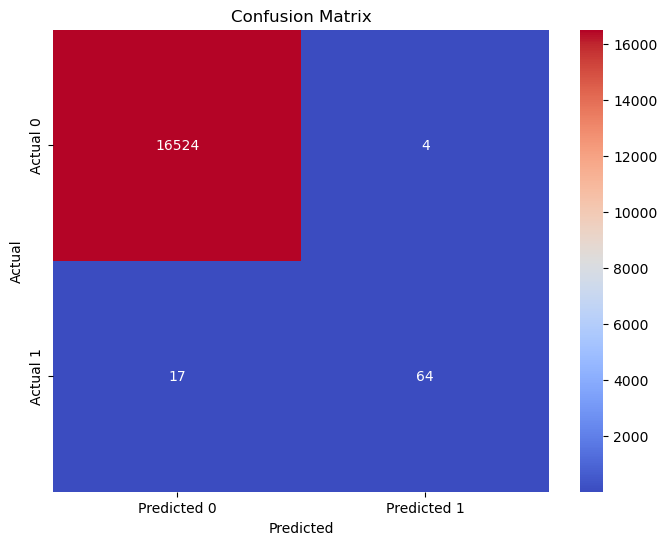

In [23]:
xgb_model_output(x_adasyn,y_adasyn,x_test, y_test)

C:\Users\w11\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning:

[17:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.




XGB Best Model Recall: 0.7901234567901234
XGB Log Loss: 0.008972914031278792
XGB Confusion Matrix: 

 [[16525     3]
 [   17    64]]


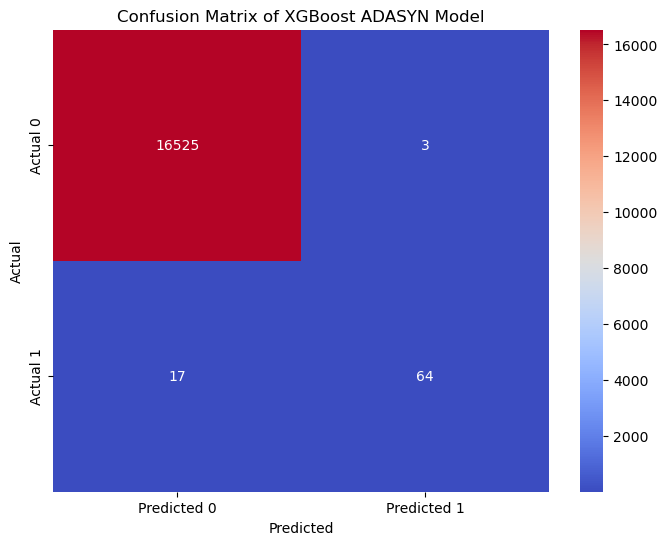

In [24]:
xgb_adasyn_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', gamma = 0, learning_rate = 0.2, max_depth = 5, n_estimator = 150, reg_alpha = 0, reg_lambda = 1)
xgb_adasyn_model.fit(x_adasyn,y_adasyn)
y_pred_adasyn_best = xgb_adasyn_model.predict(x_test)
y_prob_adasyn_best = xgb_adasyn_model.predict_proba(x_test)
recall_adasyn_best = recall_score(y_test, y_pred_adasyn_best)
LogLoss_xgb_best = log_loss(y_test, y_prob_adasyn_best)
print(f'XGB Best Model Recall: {recall_adasyn_best}')
print(f'XGB Log Loss: {LogLoss_xgb_best}')
print('XGB Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_adasyn_best))

# Displaying Confusion Matrix
cm = confusion_matrix(y_test, y_pred_adasyn_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of XGBoost ADASYN Model')
plt.show()

In [25]:
x_test.iloc[-1].to_frame().T

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,gdp_2020_value,gdp_2021_value,Avg_gdp,LogGDP,medium_none,medium_Other,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet,perBasket
62208,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31788.997,36401.883,34095.44,10.436919,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
dump(xgb_adasyn_model, 'xgb_adasyn_model.pkl')

['xgb_adasyn_model.pkl']

In [27]:
xgb_adasyn_model.predict(x_test.iloc[-1].to_frame().T)

array([0])

In [28]:
prob = np.round(xgb_adasyn_model.predict_proba(x_test.iloc[-100].to_frame().T),2)
prob

array([[1., 0.]], dtype=float32)

In [29]:
prob[:,1]

array([0.], dtype=float32)

In [30]:
prob[:,0]

array([1.], dtype=float32)

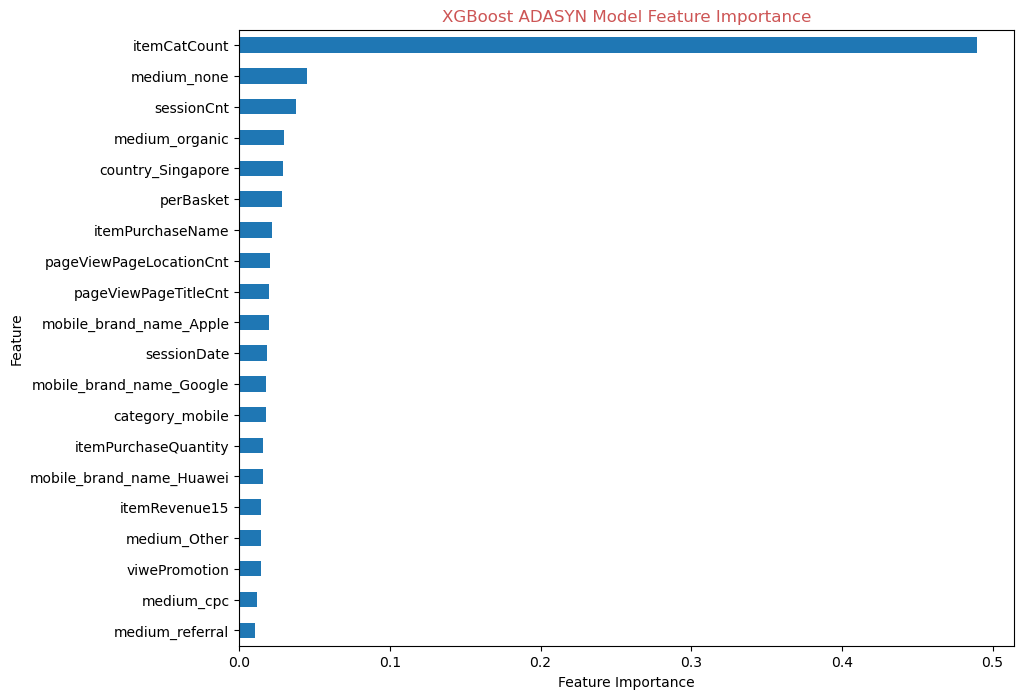

In [32]:
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(xgb_adasyn_model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('XGBoost ADASYN Model Feature Importance', color = '#cd5555')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Reverse the order to have the most important feature on top
plt.show()




In [33]:
country_filtered.head()

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP
0,10010882.0068113393,(none),(direct),(direct),Google,Canada,desktop,1,2020-11-23,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932
1,10326312.0323358273,organic,(organic),google,Apple,United States,mobile,1,2020-11-18,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570
3,10520213.5981733410,organic,(organic),google,Apple,France,mobile,1,2020-11-04,1,1,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,40529.093,45161.226,42845.1595,0,10.665348
4,1055465.0001363615,(none),(direct),(direct),Google,India,desktop,1,2020-11-12,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179,2082.8655,0,7.641500
5,1064472.7447863133,referral,(referral),<Other>,Google,Taiwan,desktop,1,2020-11-03,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,28571.440,33070.701,30821.0705,0,10.335954


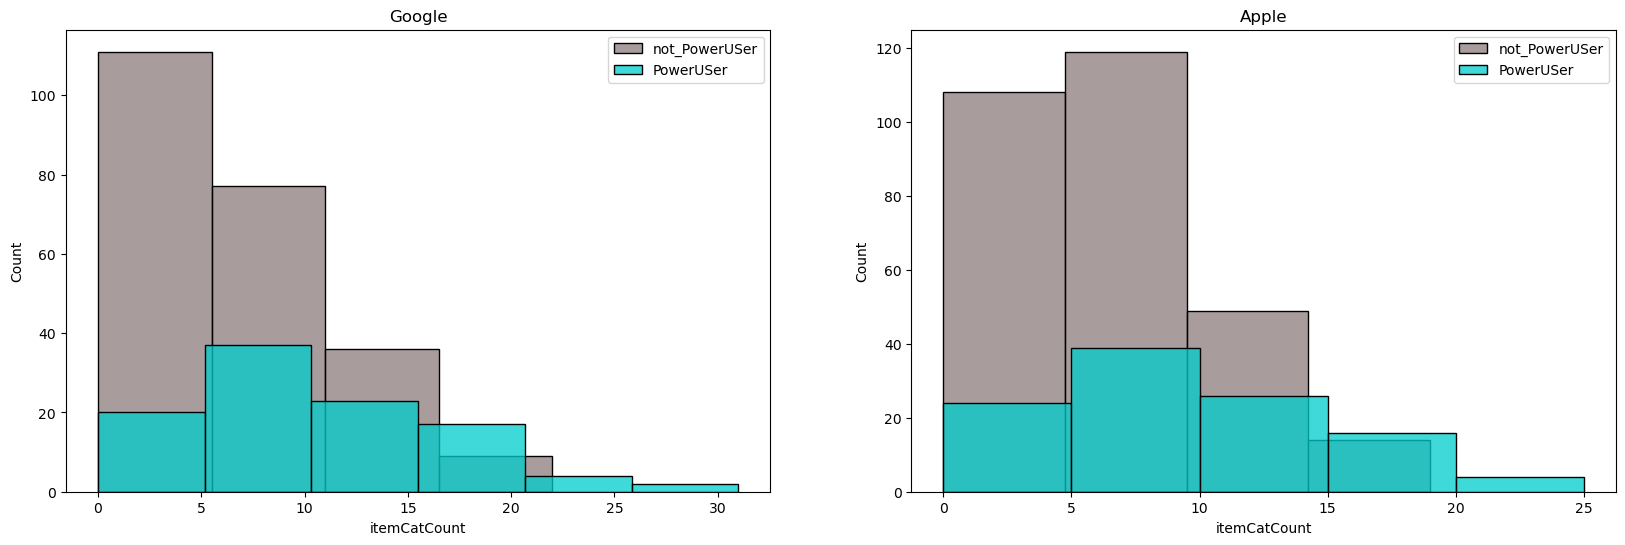

In [34]:
greaterThan0_country_filtered = country_filtered[country_filtered['itemRevenue90']>0]
Google = greaterThan0_country_filtered[greaterThan0_country_filtered['mobile_brand_name']=='Google']
Apple = greaterThan0_country_filtered[greaterThan0_country_filtered['mobile_brand_name']=='Apple']

plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(Google[Google['powerUSer']==0].itemCatCount.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Google[Google['powerUSer']==1].itemCatCount.dropna(), binwidth=5, label='PowerUSer', color = '#00cdcd')
plt.legend()
plt.title('Google')

plt.subplot(1,2,2)
sns.histplot(Apple[Apple['powerUSer']==0].itemCatCount.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Apple[Apple['powerUSer']==1].itemCatCount.dropna(), binwidth=5, label='PowerUSer' , color = '#00cdcd')
plt.legend()
plt.title('Apple');

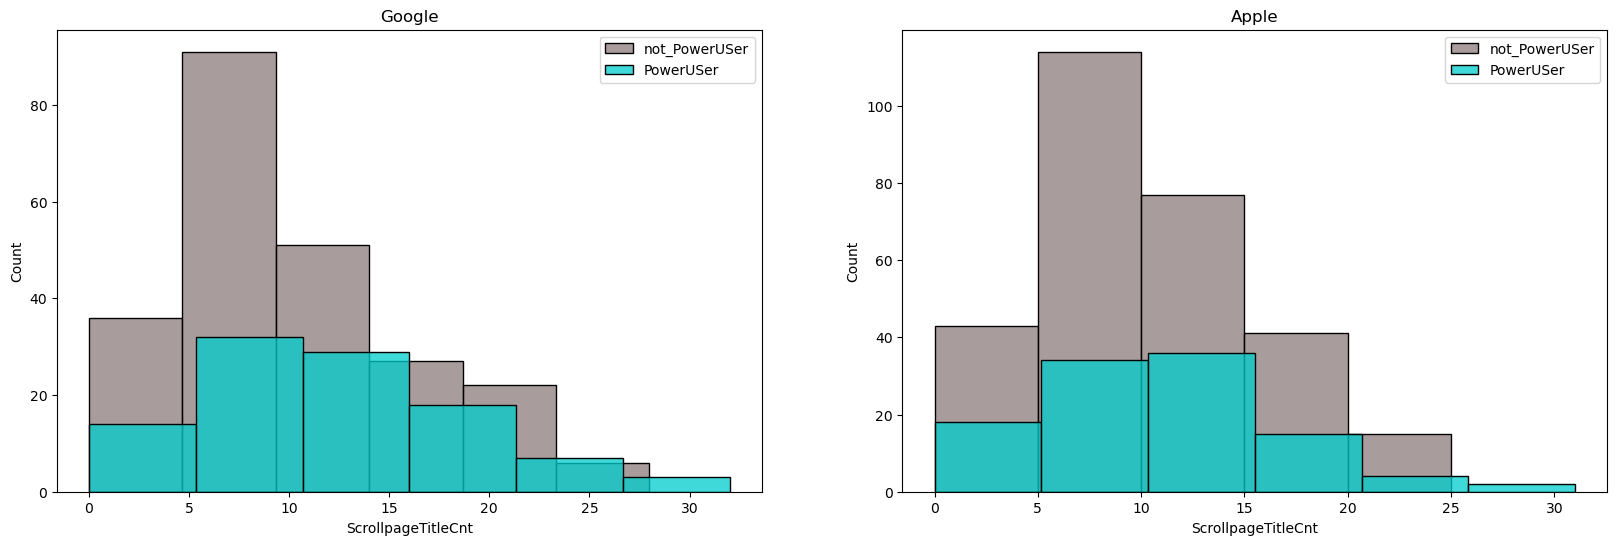

In [35]:
greaterThan0_country_filtered = country_filtered[country_filtered['itemRevenue90']>0]
Google = greaterThan0_country_filtered[greaterThan0_country_filtered['mobile_brand_name']=='Google']
Apple = greaterThan0_country_filtered[greaterThan0_country_filtered['mobile_brand_name']=='Apple']

plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(Google[Google['powerUSer']==0].ScrollpageTitleCnt.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Google[Google['powerUSer']==1].ScrollpageTitleCnt.dropna(), binwidth=5, label='PowerUSer', color = '#00cdcd')
plt.legend()
plt.title('Google')

plt.subplot(1,2,2)
sns.histplot(Apple[Apple['powerUSer']==0].ScrollpageTitleCnt.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Apple[Apple['powerUSer']==1].ScrollpageTitleCnt.dropna(), binwidth=5, label='PowerUSer' , color = '#00cdcd')
plt.legend()
plt.title('Apple');

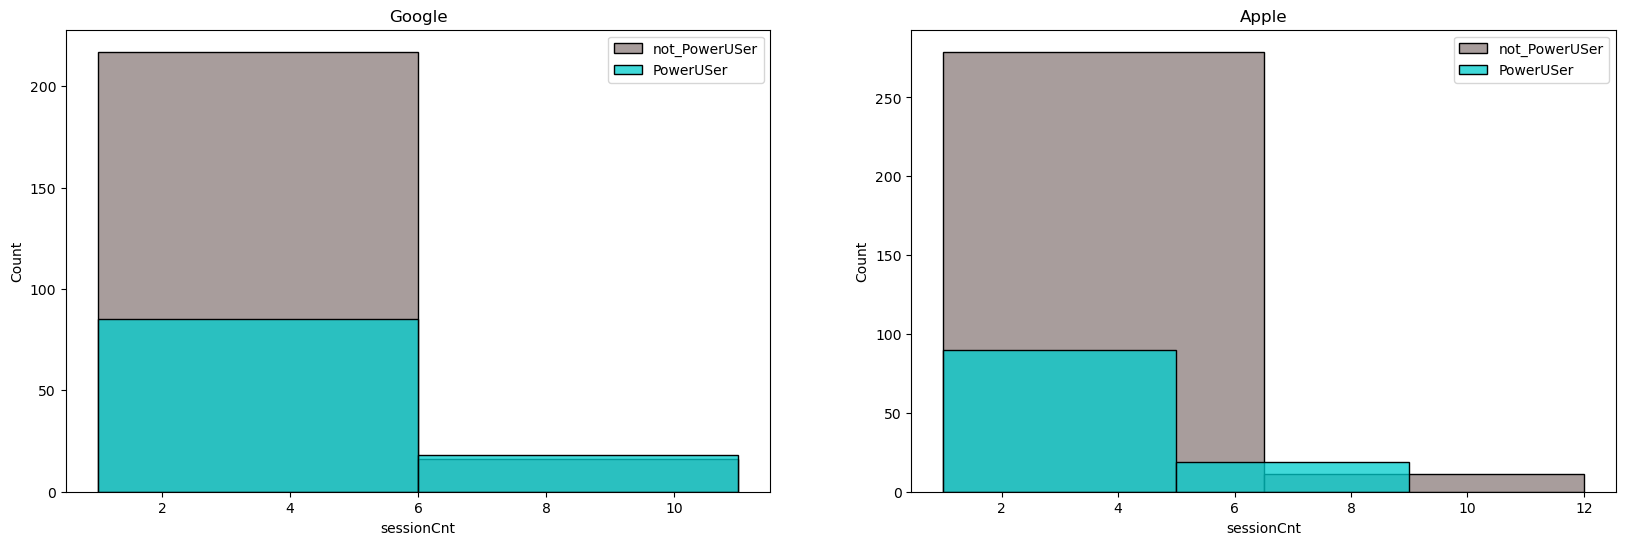

In [36]:
greaterThan0_country_filtered = country_filtered[country_filtered['itemRevenue90']>0]
Google = greaterThan0_country_filtered[greaterThan0_country_filtered['mobile_brand_name']=='Google']
Apple = greaterThan0_country_filtered[greaterThan0_country_filtered['mobile_brand_name']=='Apple']

plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(Google[Google['powerUSer']==0].sessionCnt.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Google[Google['powerUSer']==1].sessionCnt.dropna(), binwidth=5, label='PowerUSer', color = '#00cdcd')
plt.legend()
plt.title('Google')

plt.subplot(1,2,2)
sns.histplot(Apple[Apple['powerUSer']==0].sessionCnt.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Apple[Apple['powerUSer']==1].sessionCnt.dropna(), binwidth=5, label='PowerUSer' , color = '#00cdcd')
plt.legend()
plt.title('Apple');

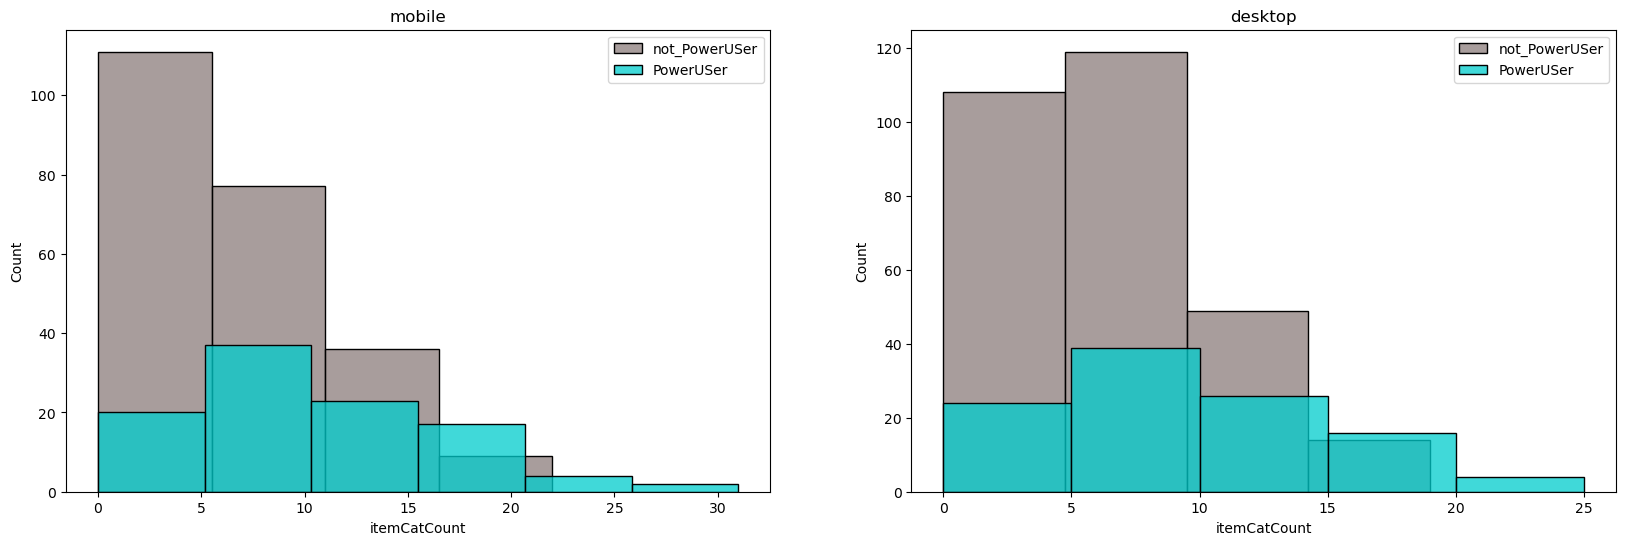

In [37]:
greaterThan0_country_filtered = country_filtered[country_filtered['itemRevenue90']>0]
mobile = greaterThan0_country_filtered[greaterThan0_country_filtered['category']=='mobile']
desktop = greaterThan0_country_filtered[greaterThan0_country_filtered['category']=='desktop']
plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(Google[Google['powerUSer']==0].itemCatCount.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Google[Google['powerUSer']==1].itemCatCount.dropna(), binwidth=5, label='PowerUSer', color = '#00cdcd')
plt.legend()
plt.title('mobile')

plt.subplot(1,2,2)
sns.histplot(Apple[Apple['powerUSer']==0].itemCatCount.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Apple[Apple['powerUSer']==1].itemCatCount.dropna(), binwidth=5, label='PowerUSer' , color = '#00cdcd')
plt.legend()
plt.title('desktop');

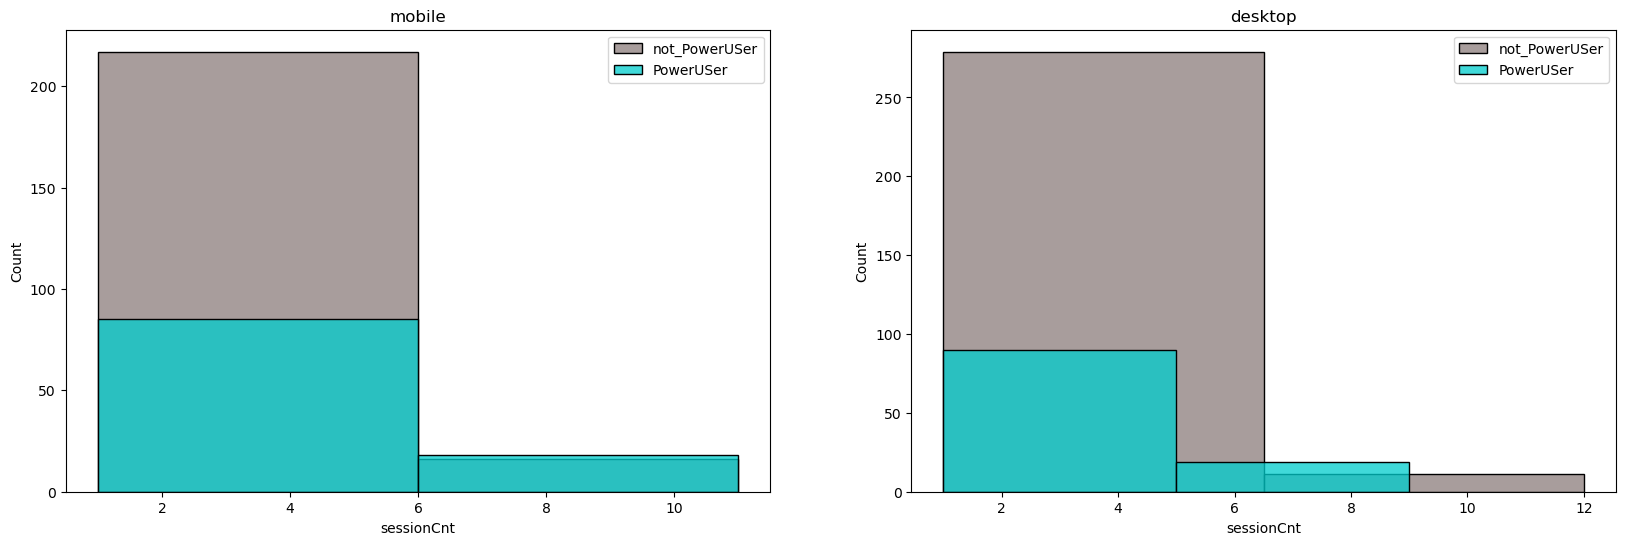

In [38]:
greaterThan0_country_filtered = country_filtered[country_filtered['itemRevenue90']>0]
mobile = greaterThan0_country_filtered[greaterThan0_country_filtered['category']=='mobile']
desktop = greaterThan0_country_filtered[greaterThan0_country_filtered['category']=='desktop']
plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(Google[Google['powerUSer']==0].sessionCnt.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Google[Google['powerUSer']==1].sessionCnt.dropna(), binwidth=5, label='PowerUSer', color = '#00cdcd')
plt.legend()
plt.title('mobile')

plt.subplot(1,2,2)
sns.histplot(Apple[Apple['powerUSer']==0].sessionCnt.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Apple[Apple['powerUSer']==1].sessionCnt.dropna(), binwidth=5, label='PowerUSer' , color = '#00cdcd')
plt.legend()
plt.title('desktop');

In [39]:
import shap
shap.initjs() 

In [40]:
explainer = shap.Explainer(xgb_adasyn_model)
shap_values_class = explainer(x_test)

In [41]:
shap_values_class

.values =
array([[-0.82955885, -1.0639535 , -0.7183199 , ..., -0.12996465,
        -0.00194989, -0.16212626],
       [ 0.0045562 , -0.16852537, -1.7375536 , ..., -0.19698139,
        -0.00498201, -0.0741729 ],
       [-0.1624307 , -0.72387576,  0.12070651, ..., -0.22330594,
        -0.00699331, -0.04113144],
       ...,
       [-0.24251303, -0.59672725, -1.7043979 , ..., -0.2329156 ,
        -0.00448113, -0.05467752],
       [-0.24251303, -0.59672725, -1.7043979 , ..., -0.2329156 ,
        -0.00448113, -0.05467752],
       [-0.21946713, -0.45563224,  0.15200861, ..., -0.18584783,
        -0.00551705, -0.03995033]], dtype=float32)

.base_values =
array([0.04501429, 0.04501429, 0.04501429, ..., 0.04501429, 0.04501429,
       0.04501429], dtype=float32)

.data =
array([[1, 1, 3, ..., 1, 0, 0.0],
       [2, 2, 0, ..., 0, 0, 0.0],
       [1, 1, 1, ..., 1, 0, 0.0],
       ...,
       [1, 1, 0, ..., 0, 0, 0.0],
       [1, 1, 0, ..., 0, 0, 0.0],
       [1, 1, 1, ..., 0, 0, 0.0]], dtype=object)

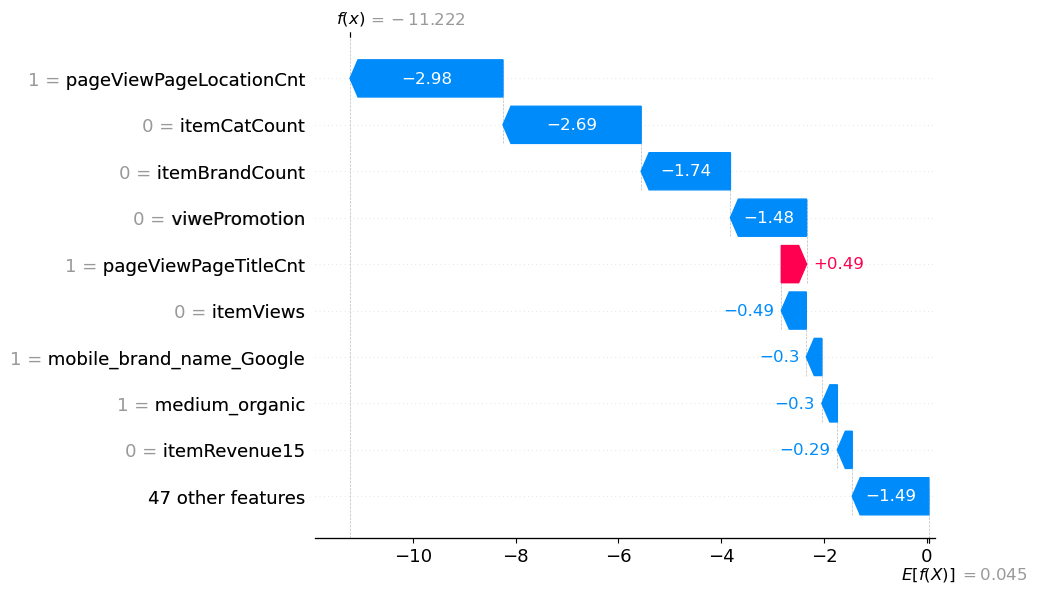

In [42]:
shap.plots.waterfall(shap_values_class[1])


In [43]:
xy_test = x_test.join(y_test)
xy_test

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,gdp_2020_value,gdp_2021_value,Avg_gdp,LogGDP,medium_none,medium_Other,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet,perBasket,powerUSer
54227,1,1,3,2,1,0,12,0,0,0,0,0,4,4,3,0,0,0,0,0,0.0,0,0,0.0,40529.093,45161.226,42845.1595,10.665348,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0
63975,2,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0
33537,1,1,1,1,2,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0
351,1,1,3,3,6,0,13,0,0,1,1,1,98,98,58,0,0,2,2,0,0.0,0,0,0.0,40529.093,45161.226,42845.1595,10.665348,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0
44551,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67702,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,43573.195,52520.512,48046.8535,10.779932,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
16876,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,43573.195,52520.512,48046.8535,10.779932,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0
36901,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0
18711,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0


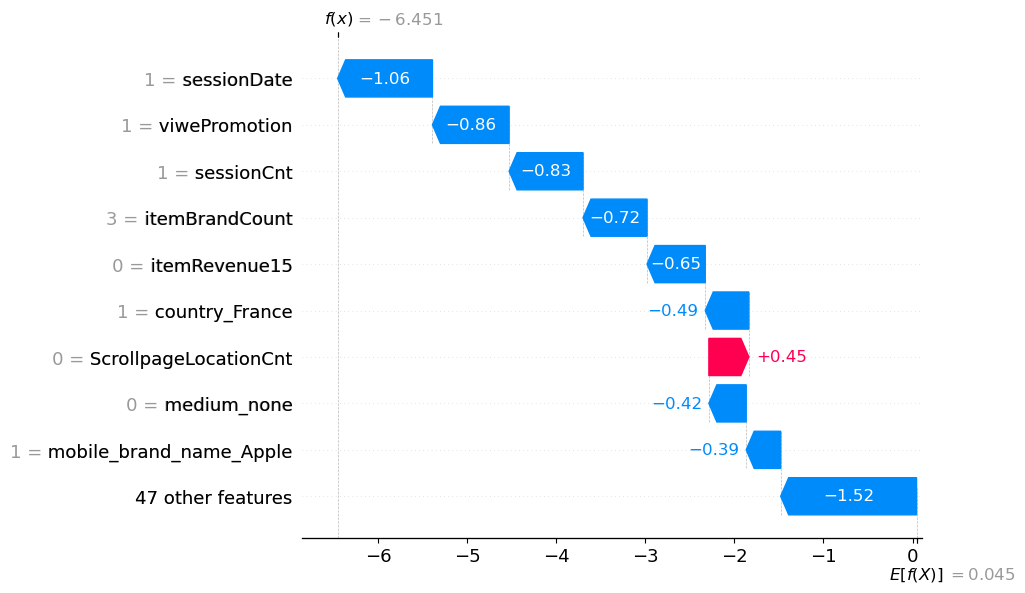

In [44]:

shap.plots.waterfall(shap_values_class[0])

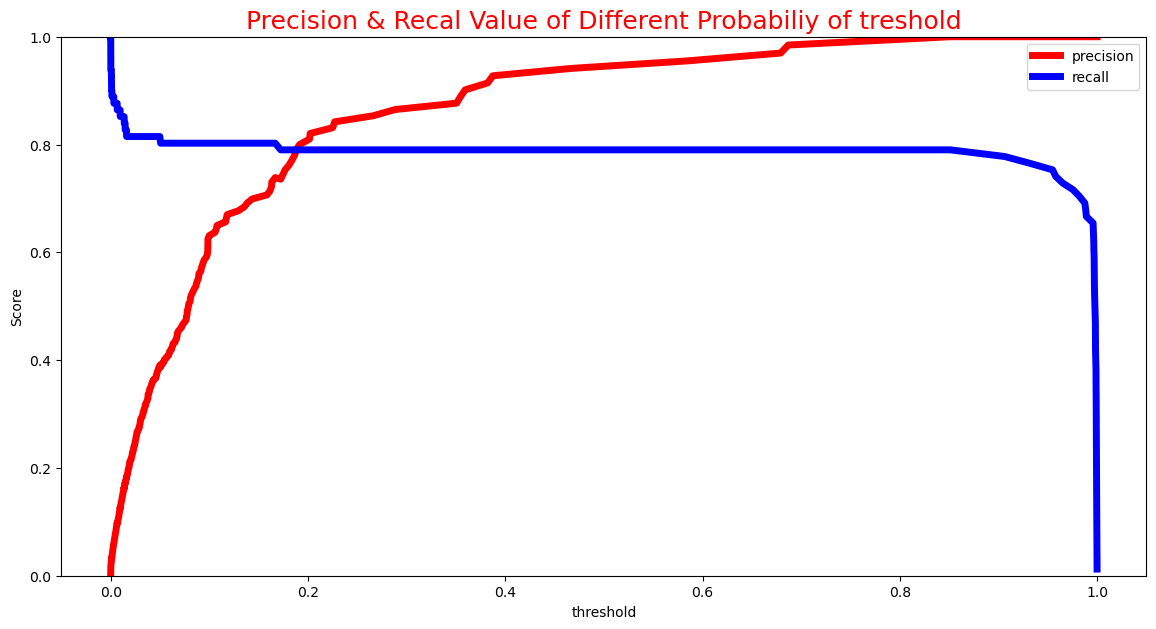

In [62]:
from sklearn.metrics import precision_recall_curve

y_scores = xgb_adasyn_model.predict_proba(x_test)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_test, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=10)
    plt.ylabel('Score', fontsize = 10)
    plt.legend(loc="upper right", fontsize=10)
    plt.ylim([0, 1])
    plt.title('Precision & Recal Value of Different Probabiliy of treshold', fontsize = 18, c = 'r')

plt.figure(figsize=[14, 7])
plot_precision_and_recall(precision, recall, threshold)

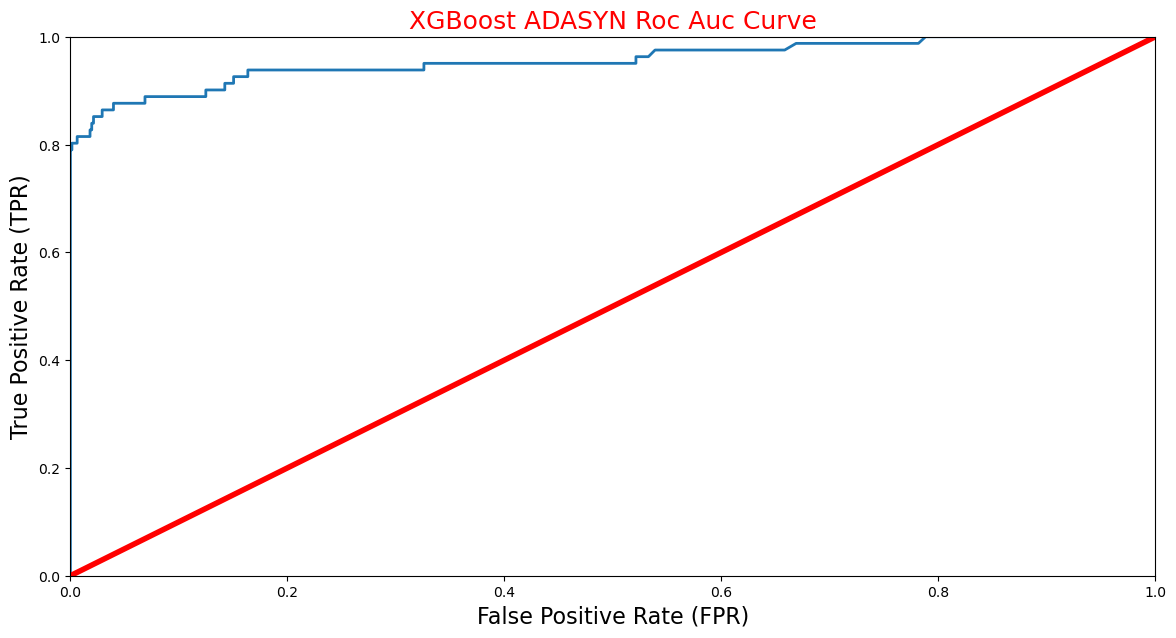

In [63]:
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.title('XGBoost ADASYN Roc Auc Curve', fontsize = 18, color = 'r')

plt.figure(figsize=[14, 7])
plot_roc_curve(false_positive_rate, true_positive_rate)

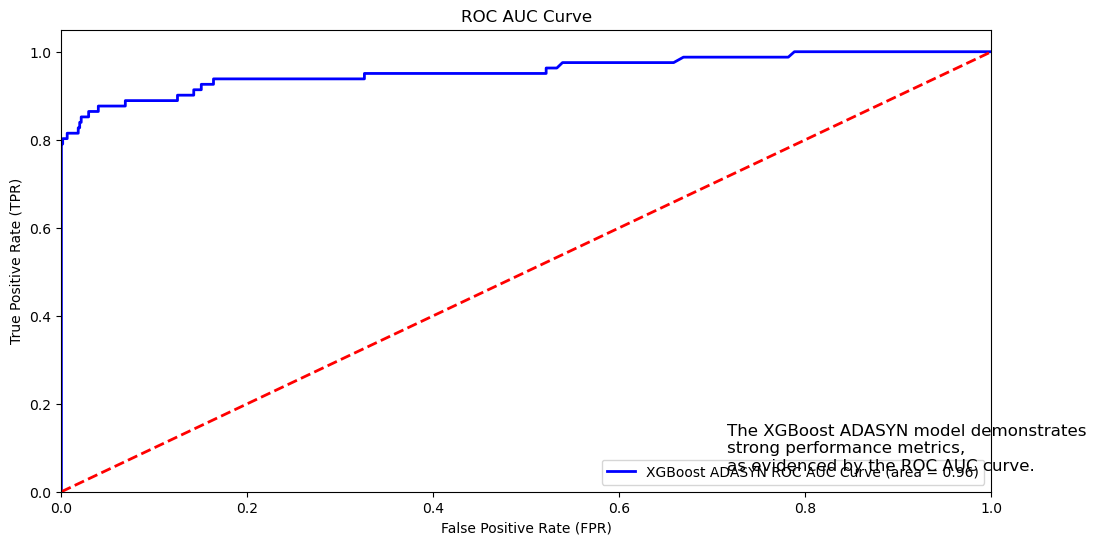

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# ROC AUC Curve için false positive rate ve true positive rate hesapla
fpr, tpr, _ = roc_curve(y_test, y_prob_adasyn_best[:, 1])
roc_auc = auc(fpr, tpr)

# ROC AUC grafiği
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='XGBoost ADASYN ROC AUC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")

# Açıklama ekleme
plt.figtext(0.68, 0.15, "The XGBoost ADASYN model demonstrates\nstrong performance metrics,\nas evidenced by the ROC AUC curve.", wrap=True, horizontalalignment='left', fontsize=12)

plt.show()


Confusion Matrix:
 [[16513    15]
 [   17    64]]
Precision: 0.810126582278481
Recall: 0.7901234567901234


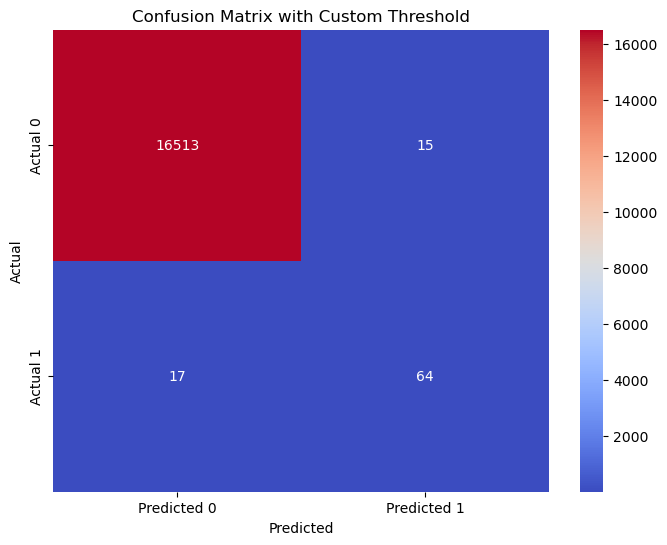

In [59]:
threshold = 0.20
y_pred_custom_threshold = (y_prob_adasyn_best[:, 1] >= threshold).astype(int)

# Yeni threshold ile performans metriklerini hesapla
from sklearn.metrics import confusion_matrix, precision_score, recall_score

cm = confusion_matrix(y_test, y_pred_custom_threshold)
print('Confusion Matrix:\n', cm)
print(f'Precision: {precision_score(y_test, y_pred_custom_threshold)}')
print(f'Recall: {recall_score(y_test, y_pred_custom_threshold)}')

# Confusion matrix grafiği
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix with Custom Threshold')
plt.show()


In [ ]:
greaterThan0_country_filtered = country_filtered[country_filtered['itemRevenue90']>0]
Google = greaterThan0_country_filtered[greaterThan0_country_filtered['mobile_brand_name']=='Google']
Apple = greaterThan0_country_filtered[greaterThan0_country_filtered['mobile_brand_name']=='Apple']

plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(Google[Google['powerUSer']==0].itemCatCount.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Google[Google['powerUSer']==1].itemCatCount.dropna(), binwidth=5, label='PowerUSer', color = '#00cdcd')
plt.legend()
plt.title('Google')

plt.subplot(1,2,2)
sns.histplot(Apple[Apple['powerUSer']==0].itemCatCount.dropna(), binwidth=5, label='not_PowerUSer', color='#8b7d7b')
sns.histplot(Apple[Apple['powerUSer']==1].itemCatCount.dropna(), binwidth=5, label='PowerUSer' , color = '#00cdcd')
plt.legend()
plt.title('Apple');